# Gazave et al. 2014 neutral region data

D. P. Rice

3/14/18 - 3/15/18

# Introduction

This is an initial exploration of the data from Gazave et al. 2014, which sequenced ~500 European individuals to high coverage at 15 putatively neutral loci. The data consist of:
1. __The target region definitions__ I've extracted these using `tesseract` OCR from Table S2
2. __The SNVs__ I've downloaded a vcf from Alon Kleinan's website and extracted the allele counts relevant fields into a simple text file using `bcftools`

The goal of this document is to perform the following quality checks:
1. The numbers in the target regions should match those in table S2 (checking for OCR errors).
2. Regions should make sense: target length = end - start, covered bases <= length.
3. Region descriptive statistics should match main text and SI claims.
4. SNV positions should be within target regions.
5. Descriptive statistics of SNVs should match claims in the paper.
6. Site frequency spectrum should match Fig. 2.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Target regions

In [3]:
targets = pd.read_table('../data/GazaveEtal/gazave_targets.txt', delim_whitespace=True, thousands=',')
targets.head()

,chr,start,end,length,n20x_1_indiv,n20x_450_indiv,nSNVs
0,1,237146097,237165997,19900,19902,19764,180
1,1,237360801,237380801,20000,20004,19539,197
2,4,164000000,164020000,20000,17962,16117,96
3,4,164115673,164135673,20000,19768,19443,119
4,6,165342001,165355001,13000,11098,10659,86


In [4]:
targets.describe()

,chr,start,end,length,n20x_1_indiv,n20x_450_indiv,nSNVs
count,15.000000,1.500000e+01,1.500000e+01,15.000000,15.000000,15.000000,15.000000
mean,6.800000,1.364851e+08,1.364995e+08,14416.000000,13667.666667,13065.866667,122.266667
std,3.233751,5.854636e+07,5.854773e+07,5279.405811,4936.985411,4731.881019,35.531609
min,1.000000,4.956573e+07,4.957973e+07,5340.000000,5285.000000,5066.000000,79.000000
25%,5.000000,8.329806e+07,8.331206e+07,11500.000000,11051.000000,10831.500000,99.500000
50%,7.000000,1.332661e+08,1.332714e+08,14000.000000,12577.000000,12002.000000,117.000000
75%,10.000000,1.653777e+08,1.653902e+08,20000.000000,18865.000000,17197.500000,128.500000
max,10.000000,2.373608e+08,2.373808e+08,20000.000000,20004.000000,19764.000000,197.000000


## Target lengths and locations

The easiest way to check for OCR errors is to check the column sums against the *Total* row of table, which says the totals are:
- length: 216,240
- 20x in 1 indiv: 205,015
- 20x in 450 indivs: 195,988
- number of snvs: 1,834

In [5]:
print('length:', targets.length.sum())
print('1 indiv:', targets.n20x_1_indiv.sum())
print('450 ind:', targets.n20x_450_indiv.sum())
print('n snvs:', targets.nSNVs.sum())

length: 216240
1 indiv: 205015
450 ind: 195988
n snvs: 1834


This checks out. There could be some subtle OCR errors, but that seems unlikely.

Now, compare length to end - start:

In [6]:
targets.end - targets.start == targets.length

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
dtype: bool

This also checks out.

The SI states that target lengths range from 5,340bp to 20,00bp.

In [7]:
(targets.length.min(), targets.length.max())

(5340, 20000)

Checks out.

The SI states that the targets were selected in pairs and triplets so that they are in partial LD. It says:
>duplets or triplets cover physical distance of 195 kb on average (range: 93 kb and 430 kb)

We can try to identify the duplets and triplets by eye and check this.

In [8]:
print(targets[['chr', 'start', 'end']])

    chr      start        end
0     1  237146097  237165997
1     1  237360801  237380801
2     4  164000000  164020000
3     4  164115673  164135673
4     6  165342001  165355001
5     6  165413304  165425304
6     6  165470500  165482500
7     7   49565734   49579734
8     7   49645200   49659200
9    10   82981023   83001023
10   10   83207715   83215715
11   10   83388407   83408407
12   10  133143109  133150109
13   10  133231083  133242083
14   10  133266053  133271393


These fall into 6 clear sets: Chr1, Chr4, Chr7, Chr10 around 83 Mb, and Chr10 around 133 Mb.

In [9]:
group_start = [0,2,4,7,9,12]
group_end = [1,3,6,8,11,14]
group_lengths = np.array(targets.end[group_end]) - np.array(targets.start[group_start])
print(group_lengths)
print('Min:', min(group_lengths))
print('Max:', max(group_lengths))
print('Avg:', np.mean(group_lengths))

[234704 135673 140499  93466 427384 128284]
Min: 93466
Max: 427384
Avg: 193335.0


The minimum is correct, but the maximum and the average are both a little low. **Maybe should double check this.**

## Coverage

For each target, the length should be greater than the number of bases with 20x coverage in one sample, which should be greater than the number of bases with 20x coverage in 450 samples. 

In [10]:
targets.length >= targets.n20x_1_indiv

0     False
1     False
2      True
3      True
4      True
5     False
6      True
7      True
8      True
9      True
10    False
11     True
12    False
13    False
14     True
dtype: bool

In [11]:
targets.n20x_1_indiv >= targets.n20x_450_indiv

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
dtype: bool

In [12]:
targets.length >= targets.n20x_450_indiv

0      True
1      True
2      True
3      True
4      True
5     False
6      True
7      True
8      True
9      True
10     True
11     True
12    False
13    False
14     True
dtype: bool

The counts for 20x coverage in at least 450 individuals are all less than the bp covered at 20x in at least 1 individual, as they should be. But there are sometimes more bases covered than the target length. Presumably, this is some sort of overhang. **I should investigate and understand this.**

In [13]:
targets.length - targets.n20x_1_indiv

0       -2
1       -4
2     2038
3      232
4     1902
5       -2
6        0
7     1423
8        0
9      128
10      -4
11    5466
12      -3
13      -4
14      55
dtype: int64

In [14]:
targets.length - targets.n20x_450_indiv

0      136
1      461
2     3883
3      557
4     2341
5       -2
6        0
7     2817
8      221
9     1722
10     622
11    7227
12      -3
13      -4
14     274
dtype: int64

When considering only sites with 20x coverage in 450 individuals, there are never more than 4 extra bases, so we might be ok neglecting this.

# Single nucleotide variants

We have the following information about the filtered list of SNVs:
- there 1,834 high quality SNVs (main text p. 759, para. 1)
- 95% of SNVs are genotyped in 450 individuals and these are the ones used in the SFS figures. (main text p. 759, para. 1)
- the proportion of singletons among variant sites is 38.4% (main text p. 759, para. 3)
- The Ti/Tv ratio is 2.22 (main text p. 759, para 1)

In [15]:
snvs = pd.read_table('../data/GazaveEtal/variants.txt', delim_whitespace=True)
snvs.head()

,CHROM,POS,REF,ALT,AN,AC,AF
0,chr7,49565781,C,A,984,9,0.0091
1,chr7,49565844,G,A,984,1,0.0010
2,chr7,49565865,C,A,984,1,0.0010
3,chr7,49566127,G,A,984,356,0.3618
4,chr7,49566144,T,C,984,1,0.0010


We need to make the CHROM column match the one from the target file.

In [16]:
snvs.CHROM = snvs.CHROM.apply(lambda s: int(s[3:]))
snvs.head()

,CHROM,POS,REF,ALT,AN,AC,AF
0,7,49565781,C,A,984,9,0.0091
1,7,49565844,G,A,984,1,0.0010
2,7,49565865,C,A,984,1,0.0010
3,7,49566127,G,A,984,356,0.3618
4,7,49566144,T,C,984,1,0.0010


## Number of SNPVs and genotype counts

In [17]:
snvs.count()

CHROM    1834
POS      1834
REF      1834
ALT      1834
AN       1834
AC       1834
AF       1834
dtype: int64

There are 1,834 SNVs in the table, suggesting that these are the "high quality" SNVs.

In [18]:
snvs.AN.describe()

count    1834.000000
mean      984.064340
std         5.164633
min       860.000000
25%       984.000000
50%       984.000000
75%       984.000000
max       986.000000
Name: AN, dtype: float64

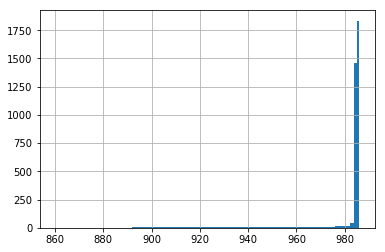

In [19]:
snvs.AN.hist(cumulative=True, bins=np.arange(860,987,1))

In [20]:
print('SNVs with fewer than 450 genotypes', (snvs.AN < 900).sum())
print('Fraction with at least 450 genotypes', (snvs.AN >= 900).sum() / snvs.AN.count())

SNVs with fewer than 450 genotypes 3
Fraction with at least 450 genotypes 0.998364231189


The proportion genotyped in at least 450 individuals is much larger than 95%. This suggests that this table was filtered after the the 95% number was calculated. On the other hand, the table cannot have been filtered on genotypes being greater than or equal to 900, because a few SNVs don't meet this criterion. This finding is potentially problematic, because it means that some of the "unobserved" sites are known to have variants. On the other hand, the number of variants is the same as reported in the main text, so something is odd here.

One thing to check is that the AN field of the .vcf really corresponds to number of genotypes called. If this is the case, then AF should equal AC/AN:

In [21]:
freqs = snvs.AC / snvs.AN
(freqs - snvs.AF).describe()

count    1834.000000
mean        0.000009
std         0.000024
min        -0.000050
25%        -0.000008
50%         0.000016
75%         0.000020
max         0.000050
dtype: float64

The differences are all in the fifth decimal place, while the AF column is only recorded to four places, suggesting that the AF = AC/AN up to a rounding error.

## Singleton fraction

In [22]:
(snvs.AC == 1).sum() / snvs.AC.count()

0.37786259541984735

In [23]:
((snvs.AC == 1) & (snvs.AN >= 900)).sum() / (snvs.AN >= 900).sum()

0.3784817039868924

The fraction of singletons is close to but not exactly 38.4%. This is true regardless of whether we filter on having 450 genotyped samples at the site. I see three possiblities:
1. The 38.4% number refers to the downsampled frequencies. (I'll test this below.)
2. The data file I've downloaded contains data that was collected after the paper was published.
3. Filters were applied to individual genotypes *after* generating the file. I can probably filter the genotypes myself from the vcf file using `bcftools`.

The relevant passage from SI p.9 on filtering individual genotypes:
> Individual genotypes were marked as missing if they presented strong allelic imbalance (> 20%), a depth of coverage < 20x or a low individual genotype quality (QC < 30), resulting in only a small amount of missing data. We established that 95% of SNVs have successful calls for at least 900 individual chromosomes out of the possible 986.

## Transitions/Transversions

In [24]:
base_table = {'A':'R', 'G':'R', 'C':'Y', 'T':'Y'}
snvs['is_TI'] = snvs.REF.replace(base_table) == snvs.ALT.replace(base_table)
snvs.is_TI.mean() / (1 - snvs.is_TI.mean())

2.2231985940246046

The Ti/Tv ratio is 2.22, as reported.

## SNV locations

Here we want to check whether all the SNVs are within target regions. If so, we might be able to ignore the potential overhangs reported above in the Target Regions section.

In [25]:
for index, row in targets.iterrows():
    snvs['in_target{}'.format(index)] = (snvs.CHROM==row.chr) & (snvs.POS >= row.start) & (snvs.POS < row.end)

In [26]:
snvs[['in_target{}'.format(i) for i in range(len(targets))]].sum(axis=1).describe()

count    1834.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64

All snvs are within exactly one target.

In [29]:
snvs.sum()

CHROM                                                      11552
POS                                                 259402467771
REF            CGCGTGGCGATGTGCGAACACAACGAGGCAGGCGAGAAATAATGGT...
ALT            AAAACAAACTCACATACGATTGTAAGAAATAATTGAGCGCGCGAAC...
AN                                                       1804774
AC                                                        195291
AF                                                       198.518
is_TI                                                       1265
in_target0                                                   180
in_target1                                                   197
in_target2                                                    96
in_target3                                                   119
in_target4                                                    86
in_target5                                                   103
in_target6                                                   122
in_target7               

In [32]:
targets.nSNVs

0     180
1     197
2      96
3     119
4      86
5     103
6     122
7     115
8     172
9     126
10     79
11    131
12     81
13    117
14    110
Name: nSNVs, dtype: int64

All targets have the right number of SNVs.

# Site frequency spectrum
The SFS for figures is calculated according to a downsampling and binning procedure described on SI P. 23:
- Remove SNVs with fewer than 900 genotyped chromosomes.
- Downsample the remaining SNVs to 900 chromosomes according to a hypergeometric distribution.
- Calculate the SFS as a histogram with bins: (1, 2, 3, 4, 5, 6-10, 11-20, 21-50, 51-100, 101-200, 201-450).
- Normalize counts by width of each bin.

In [26]:
# Define bin edges according to np.hist specification. Including 451 in the last bin to make sure the bin widths are correct.
bins = np.array([1, 2, 3, 4, 5, 6, 11, 21, 51, 101, 201, 451])
bin_widths = np.diff(bins)

In [27]:
from scipy.stats import hypergeom
n_ds = 900
counts = np.arange(n_ds+1, dtype=int)
#ds_cdf = hypergeom(snvs.AN[snvs.AN>=900], n_ds, snvs.AC[snvs.AN>=900]).cdf(bins[:,None])
ds_pmf = hypergeom(snvs.AN, n_ds, snvs.AC).pmf(counts[:,None])
ds_cdf = np.cumsum(ds_pmf, axis=0)

In [28]:
binned_pmf = np.diff(ds_cdf[bins-1,:], axis=0)
binned_sfs = np.nansum(binned_pmf, axis=1) / bin_widths
binned_sfs /= (snvs.AN >= 900).sum()

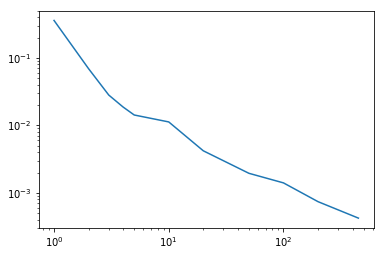

In [29]:
# Figure 1 uses the right edges of bins where the width is more than one
x = np.hstack((bins[:5], bins[6:]-1))
plt.loglog(x, binned_sfs)

In [30]:
print(binned_sfs)

[ 0.35831355  0.0691217   0.02810674  0.01868535  0.0142401   0.01123913
  0.00419944  0.00194824  0.001405    0.00074064  0.00042244]


Here's what the SFS looks like in the paper:
![Figure 2](img/gazave_fig2.png)

We are correctly reproducing the shape of the SFS, including the "bumps" at 10 and 100. However, we are showing too few singletons: 35.8% of variants vs. almost 40%.

# Conclusions

Overall, the data looks roughly as reported in the paper. Importantly, all SNVs are within target regions and we were able to reproduce the shape of the SFS. However there are a few inconsistencies:
1. For some targets, the number of bases with called genotypes is larger than the target length. This is presumably due to some sort of overhang, where more bases were sequenced than targeted. However, this excess is never more than 4 bases and no SNVs were reprorted outside of the target regions. We will need to think about this a bit when making assumptions about masked vs. monomorphic sites.
2. The maximum and average lengths of groups of nearby targets are slightly (~1%) different from what's reported in the SI. It would be nice to understand this, but I don't think it factors into our analysis at all.
3. The fraction of SNVs with at least 450 called genotypes is higher than reported (99.8% vs. 95%). This may be because the SNVs in this file have not undergone the individual genotype filtering as reported on SI p. 9.
4. The fraction of singletons sites is slightly lower than reported (37.8% vs. 38.4%). The discrepancy appears larger after downsampling (35.8%). This could be due to the differences in individual genotype filtering as in 3.